# Introduction to Convolutional Neural Networks
This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL).

### Normalize Environments
Run the first cell to setup our environment and normalize local/Colab environments,
then proceed to follow the lesson below.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/03_01_Intro_to_CNNs.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/03_01_Intro_to_CNNs.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [1]:
# Normalize local and Colab.
try:
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    IN_COLAB = True
    # Setup tensorflow 2.0
    !pip install -q tensorflow-gpu==2.0.0-beta0
except ModuleNotFoundError:
    IN_COLAB = False
import tensorflow as tf
import numpy as np

     |████████████████████████████████| 348.9MB 67kB/s 
     |████████████████████████████████| 3.1MB 36.2MB/s 
     |████████████████████████████████| 501kB 56.9MB/s 


## 1-D Convolutional Layers
The highest-profile application of deep learning is machine vision. The most popular type of network
in machine vision is a Convolutional Neural Network (CNN). As such, there are many, MANY wonderful
tutorials about CNNs free on the internet. If you have trouble following this section then please take
a moment to read through one or two CNN tutorials.

Before continuing, it's worth mentioning that CNNs were inspired by how the brain processes vision,
and researchers are using CNNs to develop models of vision that they then test with neural data.
We will talk more about that in a later session.

In image processing, you ALWAYS expect a car window to be physically higher than the tires,
so the 2-D spatial information is important for classification. In multi-channel neural data, however,
there is no reason to think that a channel carrying house-related information will ALWAYS precede a channel
with face-related information, so channel-order is not useful in a general model.
(Side note: channel order may be useful if channels are mapped to their physical locations in a normalized template space but that is out of scope.)
What is useful in neural data is the temporal relationship between samples.
While most vision-related CNNs use 2-D convolutions (or 3-D in colour images), here we are using 1-D convolutions.

[Here is a nice article](https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf)
on 1-D convolutions, and it has some good links and references at the bottom.

### 1-D Convolution as an FIR Filter in Scipy
A convolution sweeps a 'kernel' across a dataset, at each step multiplying each value in the kernel with the 
underlying sample, then outputting the sum of the products. This is exactly the same as FIR filtering.

Next we create a 35-45 Hz bandpass FIR filter and apply it to a test signal.

In [2]:
import scipy.signal

fs = 200.0            # samples per second
dur = 1.0             # duration in seconds
freqs = [15.0, 40.0]  # Peak frequencies, in Hz
amps = [2.0, 1.0]     # Sinusoidal component amplitudes
gstop = 65            # The minimum attenuation in the stopband (dB).
bandwidth = 5         # Width of the filter transition region.
filt_cuts = [35, 45]  # Filter corner frequencies (Hz)

nyq = 0.5 * fs
n_samples = int(dur * fs)
t = np.arange(n_samples) / fs  # Timestamp vector

# Create a filter
# https://scipy-cookbook.readthedocs.io/items/FIRFilter.html
N, beta = scipy.signal.kaiserord(gstop, bandwidth / nyq)
print(N)
atten = scipy.signal.kaiser_atten(N, bandwidth / nyq)
beta2 = scipy.signal.kaiser_beta(atten)
taps = scipy.signal.firwin(N, filt_cuts, nyq=nyq, pass_zero=False, window=('kaiser', beta), scale=False)
w, h = scipy.signal.freqz(taps, 1.0, worN=2000)  # frequency response

# Create an impulse signal, and a filtered copy of it
impulse = np.zeros_like(t)
impulse[int(n_samples//2)] = 1.0
imp_filt = scipy.signal.lfilter(taps, 1.0, impulse)
imp_conv = scipy.signal.convolve(impulse, taps, 'same')
# lfilter vs convolve considerations: https://scipy-cookbook.readthedocs.io/items/ApplyFIRFilter.html

# Create a signal: sum of sinusoids
x = amps[0] * np.sin(2*np.pi*freqs[0]*t) + amps[1] * np.sin(2*np.pi*freqs[1]*t)
x_filt = scipy.signal.lfilter(taps, 1.0, x)
x_conv = scipy.signal.convolve(x, taps, 'same')

160


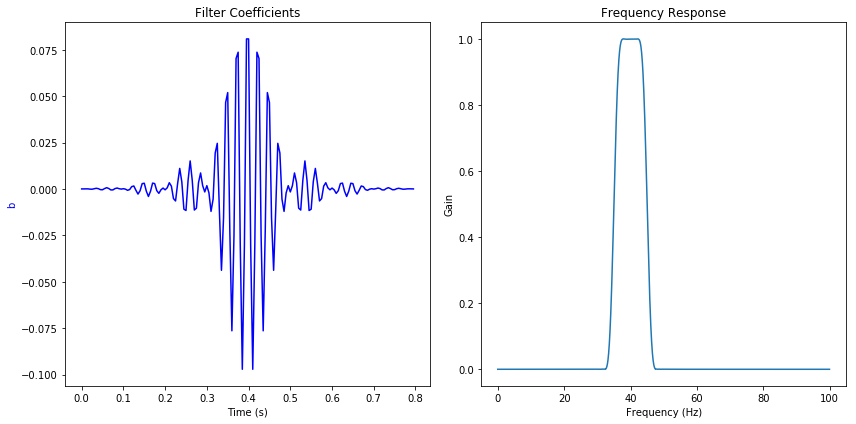

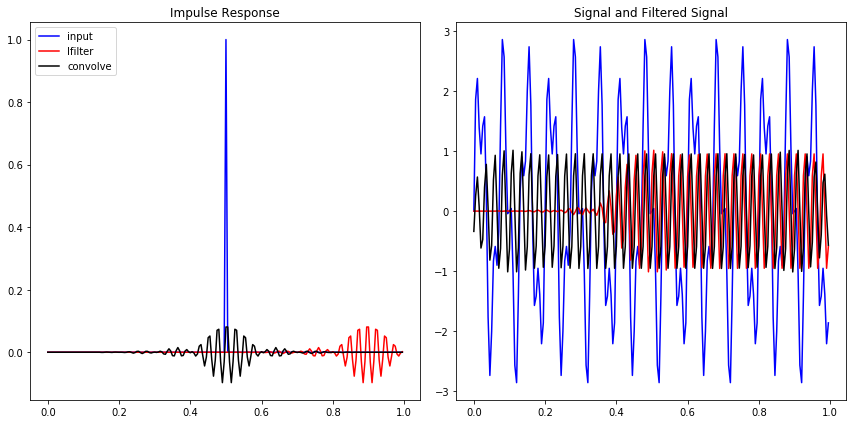

In [3]:
import matplotlib.pyplot as plt

# Describe the filter
plt.figure(figsize=(12, 6), facecolor='white')
# Plot filter coefficients
ax1 = plt.subplot(1, 2, 1)
ax1.plot(np.arange(len(taps)) / fs, taps, 'b')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('b', color='b')
plt.title('Filter Coefficients')
# Frequency response
plt.subplot(1, 2, 2)
plt.plot((fs * 0.5 / np.pi) * w, abs(h))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.title('Frequency Response')
plt.tight_layout()

# Plot signals and filtered results
plt.figure(figsize=(12, 6), facecolor='white')
# Impulse
plt.subplot(1, 2, 1)
plt.plot(t, impulse, 'b', label='input')
plt.plot(t, imp_filt, 'r', label='lfilter')
plt.plot(t, imp_conv, 'k', label='convolve')
plt.legend(loc='upper left')
plt.title('Impulse Response')
# Plot signal and filtered signal
plt.subplot(1, 2, 2)
plt.plot(t, x, 'b')
plt.plot(t, x_filt, 'r')
plt.plot(t, x_conv, 'k')
plt.title('Signal and Filtered Signal')
plt.tight_layout()

plt.show()

### 1-D Convolution as an FIR Filter in Keras
Let's create a NN model with a single 1-D convolution layer.
Then in the next cell we will "train" our model using the above filter coefficients,
and apply the model to our signal, and visualize the results.

In [4]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(1, N, padding='same', activation='linear', input_shape=(n_samples, 1)))
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 200, 1)            161       
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


### Create a CNN model that does FIR filtering
We will "train" the model by setting the weights directly with the filter kernel.

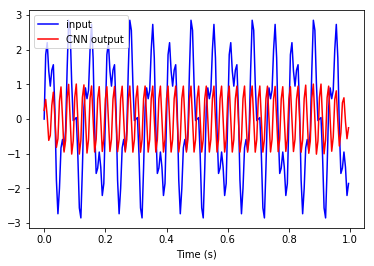

In [6]:
# "Train" our model with FIR filter weights
model.layers[0].set_weights([taps.reshape(N, 1, 1), np.array([0])])  # (filter, bias)
# Make sure they took; get the weights back and compare them
temp = model.layers[0].get_weights()[0].reshape(-1,)
assert(np.allclose(taps, temp))  # Close enough. Slightly different due to lower precision (tf 32-bit vs scipy 64-bit)
# Apply the model to our signal and visualize the output
x_cnn = model.predict(x.reshape(-1, 1)[None,])
plt.figure(figsize=(6, 4), facecolor='white')
plt.plot(t, x, 'b', label='input')
plt.plot(t, x_cnn.reshape(-1,), 'r', label='CNN output')
plt.xlabel('Time (s)')
plt.legend(loc='upper left')
plt.show()

As expected, the NN model filtered out the 15 Hz signal leaving only the 40 Hz signal. Way to ~~go~~ over-engineer! Notice that the filtered signal is tapered at the edges. This is because our model uses `padding='same'`, which pads the input with zeros so the output is the same size as the input. If we didn't, our output would only include the middle 40 samples.

### Train CNN to filter data
Let's go a little crazy. Let's learn a Conv1D layer from scratch that filters for us.
Train a Conv1D model that takes as input the 2-sinusoid signal and is optimized to output the 1-sinusoid signal.

In [8]:
# Create our data
N = 160
n_trials = 2000
batch_size = 5
n_epochs = 5
n_channels = 1
n_samples = len(t)
X = []
Y = []
for tr_idx in range(n_trials):
    t_offset = t + np.random.rand(1) / 15  # shift timestamps by up to 1/15th of a second
    y = amps[1] * np.sin(2*np.pi*freqs[1]*t_offset)
    x = amps[0] * np.sin(2*np.pi*freqs[0]*t_offset) + y
#     x += 0.5 * np.random.randn(*x.shape)  # Uncomment to add noise
    Y.append(y.reshape(n_samples, n_channels).astype(np.float32))
    X.append(x.reshape(n_samples, n_channels).astype(np.float32))
dataset = tf.data.Dataset.from_tensor_slices((X, Y))
dataset = dataset.shuffle(n_trials).batch(batch_size).repeat()
# Recreate the above model (to reset its weights)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(1, N, padding='same', activation='linear', input_shape=(n_samples, n_channels)))
model.compile(loss='mse', optimizer='rmsprop')
# Train
history = model.fit(x=dataset, epochs=n_epochs, steps_per_epoch=n_trials // batch_size)

Epoch 1/5
400/400 [==============================] - 1s 3ms/step - loss: 0.0705
Epoch 2/5
400/400 [==============================] - 1s 2ms/step - loss: 0.0170
Epoch 3/5
400/400 [==============================] - 1s 2ms/step - loss: 0.0134
Epoch 4/5
400/400 [==============================] - 1s 2ms/step - loss: 0.0118
Epoch 5/5
400/400 [==============================] - 1s 2ms/step - loss: 0.0109


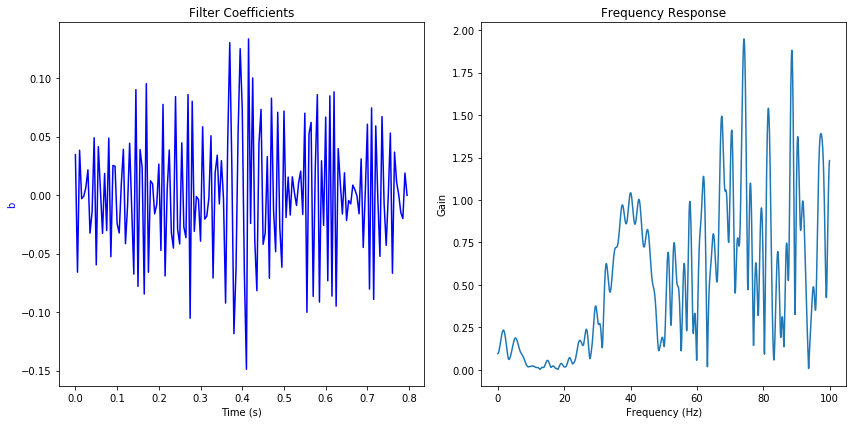

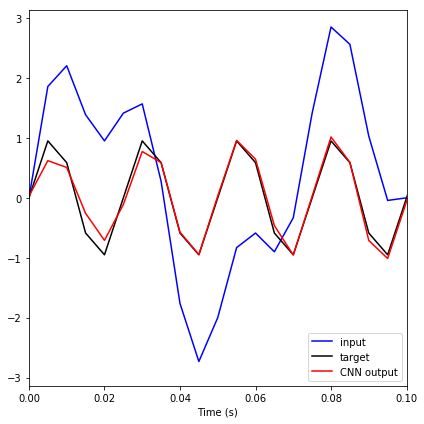

In [9]:
coefs = model.layers[0].get_weights()[0].reshape(-1, 1)
w, h = scipy.signal.freqz(coefs, 1.0, worN=2000)  # frequency response

# Plot filter design
plt.figure(figsize=(12, 6), facecolor='white')
# Filter coefficients
ax1 = plt.subplot(1, 2, 1)
ax1.plot(np.arange(len(coefs)) / fs, coefs, 'b')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('b', color='b')
plt.title('Filter Coefficients')
# Frequency response
plt.subplot(1, 2, 2)
plt.plot((fs * 0.5 / np.pi) * w, abs(h))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.title('Frequency Response')
plt.tight_layout()

# Plot signals
plt.figure(figsize=(6, 6), facecolor='white')
y = amps[1] * np.sin(2*np.pi*freqs[1]*t)
x = amps[0] * np.sin(2*np.pi*freqs[0]*t) + y
x_cnn = model.predict(x.reshape(-1, 1)[None,])
plt.plot(t, x, 'b', label='input')
plt.plot(t, y, 'k', label='target')
plt.plot(t, x_cnn.reshape(-1,), 'r', label='CNN output')
plt.xlabel('Time (s)')
plt.xlim([0, 0.1])
plt.legend(loc='lower right')
plt.tight_layout()

plt.show()

The reconstruction is pretty good. Notice that the frequency response in the high-frequencies is large.
This is because there is essentially no penalty for allowing high-frequencies through as our signals have no high-frequency content.

## Exercise

Go back above 2 cells to when the model was trained and uncomment the line to add noise, then run the cells again. If you are really eager / bored, then you could try removing the padding option from the Conv1D layer, but don't forget to also slice the y-arrays before adding them to the Y list ([N:-N], I think, there might be a +1 or -1 in there).

If instead of trying to reconstruct a signal, our (deep) model is trying to decode a brain state, and one or more layers in the deep model are convolutional layers, then the model might learn filters with passbands that are optimal for the task.